Load dependencies:

In [1]:
# !pip install opensmile
!pip install tensorflow_io
import os
import numpy as np
import librosa
# import opensmile
import math
import scipy
import tensorflow as tf
import tensorflow_io as tfio

directory = "/content/drive/MyDrive/PatientVoiceAI/data"

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 MB 14.3 MB/s eta 0:00:00


Load and preprocess raw audio files in the dataset:

In [3]:
def preprocess(x, chunksize):
    x_len = len(x)
    if x_len < chunksize:   # padding
        processed = np.pad(x, (0,chunksize-x_len))  # right-pad with zero
    elif x_len > chunksize: # splitting
        tailing = x_len % chunksize
        if tailing != 0:                # handle uneven splits: create overlap for the last chunk
            x = np.concatenate((x[:-tailing], x[-chunksize:]))
        num_chunks = int(round(len(x)/chunksize))
        processed = np.array_split(x,num_chunks)
    else:                   # no change
        processed = np.array(x)
    return processed

def get_dataset(label, label_index, chunksize):
    x_set = []
    folder = os.path.join(directory, label)
    for filename in os.listdir(folder):
        f = os.path.join(folder, filename)
        if os.path.isfile(f):
            audio, sample_rate = librosa.load(f)
            x_set.append(preprocess(audio,chunksize))
    x_set = np.vstack(x_set)
    y_set = np.repeat([label_index[label]],len(x_set))
    return x_set,y_set


classes = ["coughing", "sneezing", "speech", "silence"]

label_index = {
    "coughing":0,
    "sneezing":1,
    "speech":2,
    "silence":3
}

sample_rate = 22050   # default sample rate in librosa
chunksize = 1*sample_rate   # 1 second


## initialise the dataset
x_set = []
y_set = []
for label in classes:
    x_subset, y_subset = get_dataset(label,label_index,chunksize)
    x_set.extend(x_subset)
    y_set.extend(y_subset)

x_set = np.asarray(x_set).astype('float32')
y_set = np.asarray(y_set)

print(np.shape(x_set))
print(x_set[0])
print(np.shape(y_set))
print(y_set[0])



(13143, 22050)
[0.03695566 0.04142303 0.01117673 ... 0.         0.         0.        ]
(13143,)
0


Store the dataset into a .csv file:

In [4]:
preprocessed_dataset = np.hstack((x_set, np.expand_dims(y_set,axis=1)))
np.savetxt('preprocessed_dataset.csv', preprocessed_dataset, fmt="%d", delimiter=",")

Shuffle and split the dataset:

In [5]:
#Parameters for shuffling
seed = 42
np.random.seed(seed)
N = len(y_set)

shuffled_indices = np.random.permutation(N)

# Apply the shuffled indices to both data and labels
x_set = x_set[shuffled_indices]
y_set = y_set[shuffled_indices]


split_size_val = int(0.8*N)
split_size_test = int(0.9*N)

x_train, x_val, x_test = x_set[:split_size_val], x_set[split_size_val:split_size_test], x_set[split_size_test:]
y_train, y_val, y_test = y_set[:split_size_val], y_set[split_size_val:split_size_test], y_set[split_size_test:]

print(np.shape(x_train))
print(np.shape(x_val))
print(np.shape(x_test))

(10514, 22050)
(1314, 22050)
(1315, 22050)


Define a function to calculate normalised Mel-spectrogram:

In [6]:
def get_normalised_mel_spectrogram(x, sr=sample_rate, n_mel_bins=20):
    """
            Code adapted from https://github.com/douglas125/SpeechCmdRecognition/blob/master/audioUtils.py#L93
    """
    spec_stride = 128
    spec_len = 1024

    spectrogram = tfio.audio.spectrogram(
        x, nfft=spec_len, window=spec_len, stride=spec_stride
    )

    num_spectrogram_bins = spec_len // 2 + 1  # spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz = 40.0, 8000.0
    num_mel_bins = n_mel_bins
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    avg = tf.math.reduce_mean(log_mel_spectrograms)
    std = tf.math.reduce_std(log_mel_spectrograms)

    return (log_mel_spectrograms - avg) / std


# testing
# print(get_normalised_mel_spectrogram(x_set[1]))

Define a function to calculate MFCCs:

In [ ]:
def get_mfccs(x, sr=sample_rate, n=20, deltas=False):
    """
        Code adapted from https://github.com/genzen2103/Speaker-Recognition-System-using-GMM/blob/master/MFCC_speaker_recog.py
    """

    # calculate MFCCs
    mfccs = librosa.feature.mfcc(y=x, n_mfcc=n, sr=sr)
    if not deltas:
        return tf.transpose(tf.convert_to_tensor(mfccs))        # shape: (len,n)

    # calculate delta MFCCs
    delta_MFCC = np.zeros(mfccs.shape)
    for t in range(delta_MFCC.shape[1]):
        index_t_minus_one,index_t_plus_one=t-1,t+1

        if index_t_minus_one<0:
            index_t_minus_one=0
        if index_t_plus_one>=delta_MFCC.shape[1]:
            index_t_plus_one=delta_MFCC.shape[1]-1

        delta_MFCC[:,t]=0.5*(mfccs[:,index_t_plus_one]-mfccs[:,index_t_minus_one])

    # calculate double delta MFCCs
    double_delta_MFCC = np.zeros(mfccs.shape)
    for t in range(double_delta_MFCC.shape[1]):

        index_t_minus_one,index_t_plus_one, index_t_plus_two,index_t_minus_two=t-1,t+1,t+2,t-2

        if index_t_minus_one<0:
            index_t_minus_one=0
        if index_t_plus_one>=delta_MFCC.shape[1]:
            index_t_plus_one=delta_MFCC.shape[1]-1
        if index_t_minus_two<0:
            index_t_minus_two=0
        if index_t_plus_two>=delta_MFCC.shape[1]:
            index_t_plus_two=delta_MFCC.shape[1]-1

        double_delta_MFCC[:,t]=0.1*( 2*mfccs[:,index_t_plus_two]+mfccs[:,index_t_plus_one]
                                    -mfccs[:,index_t_minus_one]-2*mfccs[:,index_t_minus_two] )

    Combined_MFCC_F = np.concatenate((mfccs,delta_MFCC,double_delta_MFCC),axis=1)

    return tf.transpose(tf.convert_to_tensor(Combined_MFCC_F))       # shape: (len,n)


# testing
# print(get_mfccs(x_set[1],deltas=True))

tf.Tensor(
[[-3.42309814e+02  6.70312424e+01 -4.58366814e+01 ...  5.67506981e+00
   3.93562078e+00  8.09024048e+00]
 [-2.98740570e+02  6.68942490e+01 -5.86018791e+01 ...  4.28615570e+00
   3.94677877e+00  7.15044618e-01]
 [-2.72402649e+02  5.22381516e+01 -5.74585648e+01 ...  2.44150209e+00
   6.66082668e+00 -2.56417036e+00]
 ...
 [ 9.74413681e+00 -3.44650054e+00 -1.69657040e+01 ... -2.94731402e+00
  -1.86145389e+00 -6.29485548e-01]
 [-1.72532444e+01  8.55619073e-01 -9.25893974e+00 ...  3.93066078e-01
   1.92945671e+00  1.31686240e-01]
 [-2.19806271e+01  2.00257182e+00 -3.69728255e+00 ...  6.19387031e-01
   2.66373444e+00  9.67200398e-01]], shape=(132, 20), dtype=float64)


Build a model:

In [10]:
"""
      Code adapted from https://github.com/douglas125/SpeechCmdRecognition/blob/master/SpeechModels.py
"""

from tensorflow import keras
from keras import layers as L
from keras import backend as K
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from keras import optimizers
from keras.models import Model, load_model

def get_melspec_model(iLen=None):
    inp = L.Input((iLen,), name='input')
    mel_spec = get_normalised_mel_spectrogram(inp)
    melspecModel = Model(inputs=inp, outputs=mel_spec, name='normalised_spectrogram_model')
    return melspecModel

def AttRNNSpeechModel(nCategories, samplingrate=sample_rate,
                      inputLength=chunksize, rnn_func=L.LSTM):
    # simple LSTM
    sr = samplingrate
    iLen = inputLength

    inputs = L.Input((inputLength,), name='input')

    m =  get_melspec_model(iLen=inputLength)
    m.trainable = False

    x = m(inputs)
    x = tf.expand_dims(x, axis=-1, name='mel_stft')

    x = L.Conv2D(10, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)
    x = L.Conv2D(1, (5, 1), activation='relu', padding='same')(x)
    x = L.BatchNormalization()(x)

    # x = Reshape((125, 80)) (x)
    # keras.backend.squeeze(x, axis)
    x = L.Lambda(lambda q: K.squeeze(q, -1), name='squeeze_last_dim')(x)

    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]
    x = L.Bidirectional(rnn_func(64, return_sequences=True)
                        )(x)  # [b_s, seq_len, vec_dim]

    # xFirst = L.Lambda(lambda q: q[:, -1])(x)  # [b_s, vec_dim]
    # query = L.Dense(128)(xFirst)

    # # dot product attention
    # attScores = L.Dot(axes=[1, 2])([query, x])
    # attScores = L.Softmax(name='attSoftmax')(attScores)  # [b_s, seq_len]

    # # rescale sequence
    # attVector = L.Dot(axes=[1, 1])([attScores, x])  # [b_s, vec_dim]

    # for classification
    x = L.GlobalAveragePooling1D()(x)
    x = L.Dense(64, activation='relu')(x)      #(attVector)
    x = L.Dense(32)(x)

    output = L.Dense(nCategories, activation='softmax', name='output')(x)

    model = Model(inputs=[inputs], outputs=[output])

    return model

Create a model:

In [21]:
nCategs = len(classes)
model = AttRNNSpeechModel(nCategs, samplingrate = sample_rate, inputLength = None)#, rnn_func=L.LSTM)

model.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, None)]            0         
                                                                 
 normalised_spectrogram_mod  (None, None, 20)          0         
 el (Functional)                                                 
                                                                 
 tf.expand_dims_2 (TFOpLamb  (None, None, 20, 1)       0         
 da)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, None, 20, 10)      60        
                                                                 
 batch_normalization_4 (Bat  (None, None, 20, 10)      40        
 chNormalization)                                                
                                                           

Train the model:

In [12]:
import math
def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop,
            math.floor((1+epoch)/epochs_drop))

    if (lrate < 4e-5):
        lrate = 4e-5

    print('Changing learning rate to {}'.format(lrate))
    return lrate

lrate = LearningRateScheduler(step_decay)
earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5,
                             verbose=1, restore_best_weights=True)
checkpointer = ModelCheckpoint('model-spec-RNN.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results = model.fit(x_train, y_train, batch_size=32, epochs=50, validation_data=(x_val,y_val), use_multiprocessing=False,
                    callbacks=[earlystopper, checkpointer, lrate])



Changing learning rate to 0.001
Epoch 1/50
329/329 [==============================] - ETA: 0s - loss: 0.3616 - sparse_categorical_accuracy: 0.8738
Epoch 1: val_sparse_categorical_accuracy improved from -inf to 0.87595, saving model to model.h5
329/329 [==============================] - 25s 46ms/step - loss: 0.3616 - sparse_categorical_accuracy: 0.8738 - val_loss: 0.3233 - val_sparse_categorical_accuracy: 0.8760 - lr: 0.0010
Changing learning rate to 0.001
Epoch 2/50
  1/329 [..............................] - ETA: 10s - loss: 0.1598 - sparse_categorical_accuracy: 0.9375

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


329/329 [==============================] - ETA: 0s - loss: 0.1905 - sparse_categorical_accuracy: 0.9335
Epoch 2: val_sparse_categorical_accuracy improved from 0.87595 to 0.93760, saving model to model.h5
329/329 [==============================] - 11s 35ms/step - loss: 0.1905 - sparse_categorical_accuracy: 0.9335 - val_loss: 0.1951 - val_sparse_categorical_accuracy: 0.9376 - lr: 0.0010
Changing learning rate to 0.001
Epoch 3/50
329/329 [==============================] - ETA: 0s - loss: 0.1439 - sparse_categorical_accuracy: 0.9522
Epoch 3: val_sparse_categorical_accuracy improved from 0.93760 to 0.95129, saving model to model.h5
329/329 [==============================] - 11s 34ms/step - loss: 0.1439 - sparse_categorical_accuracy: 0.9522 - val_loss: 0.1565 - val_sparse_categorical_accuracy: 0.9513 - lr: 0.0010
Changing learning rate to 0.001
Epoch 4/50
328/329 [============================>.] - ETA: 0s - loss: 0.1267 - sparse_categorical_accuracy: 0.9580
Epoch 4: val_sparse_categorical_ac

Plot the training history:

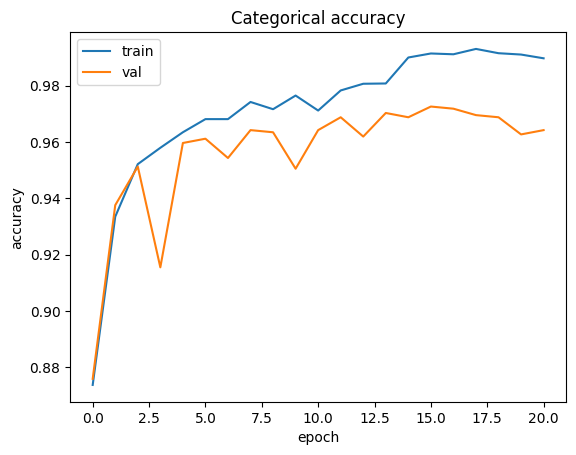

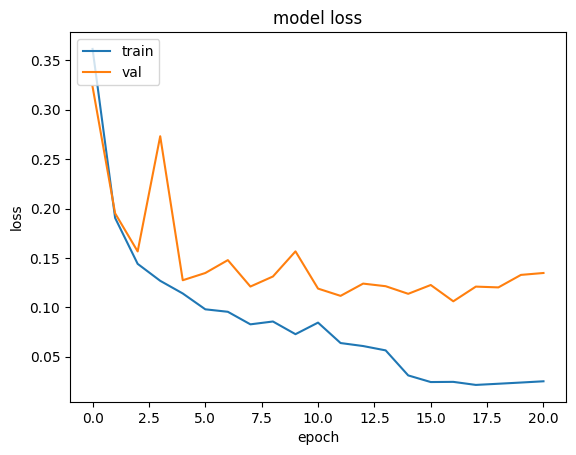

In [15]:
import matplotlib.pyplot as plt

# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

Load the previously saved weights:

In [23]:
# load the previously saved weights
model.load_weights('/content/drive/MyDrive/PatientVoiceAI/saved_models/model-spec-RNN.h5')

Evaluate on the test set:

In [24]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.11663075536489487
Test accuracy: 0.970342218875885


Perform predictions on the test set and calculate the confusion matrix:

In [17]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(x_test, verbose=1)
y_pred = np.argmax(y_pred,1)
cm = confusion_matrix(y_test, y_pred)
print(cm)

42/42 [==============================] - 3s 21ms/step
[[547   2  12   0]
 [  6  79   9   0]
 [  7   3 640   0]
 [  0   0   0  10]]


Function to predict for an external audio:

In [18]:
classes = np.asarray(classes)

def predict_framewise(x, chunksize=chunksize, model=model):
    # preprocess the input audio
    x = np.asarray(preprocess(x, chunksize)).astype('float32')
    # feed it into the model to produce predictions
    y_pred = model.predict(x)
    y_pred_probs = np.max(y_pred, axis=1)   # the probability of the highest scoring class
    y_pred_categorical = np.argmax(y_pred, axis=1)
    y_pred_labels = classes[y_pred_categorical]   # the label of the highest scoring class
    return y_pred_labels, y_pred_probs

A plotter to plot the prediction result for the audio:

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter

class TimescalePlotter:
    def __init__(self, time_values:list, label_values:list, prob_values:list, filename:str, gold_label:str, color_map={'coughing': 'red', 'sneezing': 'blue', 'speech': 'green', 'silence': 'grey'}):
        data = {
            'Time': time_values,
            'Label': label_values,
            'Probability': prob_values,
        }
        if len(time_values) != len(label_values):
            print(len(time_values))
            print(len(label_values))
        self.df = pd.DataFrame(data)
        self.color_map = color_map
        self.intervals = self._get_intervals()
        self.merged_intervals = self._merge_intervals()     # neglecting probs
        self.title = "Gold label: "+gold_label
        self.filename = filename[:-4]

    def _merge_intervals(self):
        merged_intervals = []
        current_label = self.df['Label'].iloc[0]
        start_time = self.df['Time'].iloc[0]

        for i in range(1, len(self.df)):
            if self.df['Label'].iloc[i] != current_label:
                merged_intervals.append((start_time, self.df['Time'].iloc[i], current_label))
                current_label = self.df['Label'].iloc[i]
                start_time = self.df['Time'].iloc[i]

        # Add the last interval
        merged_intervals.append((start_time, self.df['Time'].iloc[-1] + 1, current_label))
        return merged_intervals

    def _get_intervals(self):
        intervals = []
        current_label = self.df['Label'].iloc[0]
        current_prob = self.df['Probability'].iloc[0]
        start_time = self.df['Time'].iloc[0]

        for i in range(1, len(self.df)):
            intervals.append((start_time, self.df['Time'].iloc[i], current_label, current_prob))
            current_label = self.df['Label'].iloc[i]
            current_prob = self.df['Probability'].iloc[i]
            start_time = self.df['Time'].iloc[i]

        # Add the last interval
        intervals.append((start_time, self.df['Time'].iloc[-1] + 1, current_label, current_prob))
        return intervals

    def plot(self, figsize=(20, 2)):
        fig, ax = plt.subplots(figsize=figsize)  # Adjust the height by setting figsize to (width, height)

        ## Add colored intervals regardless of probabilities
        # for start_time, end_time, label in self.merged_intervals:
        #     ax.axvspan(start_time, end_time, color=self.color_map[label], alpha=0.3, label=label)

        # Add colored intervals with transparencies corresponding to probabilities
        for start_time, end_time, label, prob in self.intervals:
            ax.axvspan(start_time, end_time, color=self.color_map[label], alpha=prob, label=label)

        # Add dummy entries for labels not present in data
        for label, color in self.color_map.items():
            if label not in self.df['Label'].unique():
                ax.axvspan(np.NaN, np.NaN, color=color, alpha=0.3, label=label)

        # Formatting the plot
        ax.set_xlim(self.df['Time'].min() - 1, self.df['Time'].max() + 2)  # Adjust x-axis limits
        ax.set_ylim(0.5, 1.5)  # Adjust y-axis limits to focus on the labels
        ax.set_xlabel('Time (seconds)')
        ax.set_ylabel('Label')
        ax.set_title(self.title)  # Set the plot title

        # Customizing ticks and grid
        ax.xaxis.set_major_locator(plt.MaxNLocator(10))  # Show up to 10 major ticks on the x-axis
        ax.yaxis.set_visible(False)  # Hide y-axis
        ax.grid(True, which='both', axis='x', linestyle='--', linewidth=0.5)

        # Create a legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys(), loc='upper right')

        # Display the plot
        plt.show()

Test an example of an external audio:

4/4 [==============================] - 0s 47ms/step
['speech' 'speech' 'speech' 'coughing' 'speech' 'speech' 'speech' 'speech'
 'speech' 'speech' 'coughing' 'coughing' 'speech' 'speech' 'speech'
 'speech' 'speech' 'sneezing' 'speech' 'speech' 'sneezing' 'speech'
 'speech' 'speech' 'speech' 'coughing' 'coughing' 'speech' 'coughing'
 'coughing' 'coughing' 'speech' 'speech' 'speech' 'sneezing' 'coughing'
 'speech' 'speech' 'coughing' 'speech' 'coughing' 'coughing' 'sneezing'
 'sneezing' 'sneezing' 'sneezing' 'coughing' 'coughing' 'speech' 'speech'
 'speech' 'speech' 'speech' 'speech' 'speech' 'speech' 'coughing' 'speech'
 'speech' 'speech' 'speech' 'coughing' 'speech' 'speech' 'speech'
 'coughing' 'sneezing' 'speech' 'speech' 'speech' 'sneezing' 'sneezing'
 'coughing' 'sneezing' 'coughing' 'speech' 'speech' 'coughing' 'speech'
 'sneezing' 'speech' 'speech' 'speech' 'speech' 'speech' 'speech' 'speech'
 'speech' 'speech' 'speech' 'coughing' 'speech' 'speech' 'speech' 'speech'
 'speech' 'spe

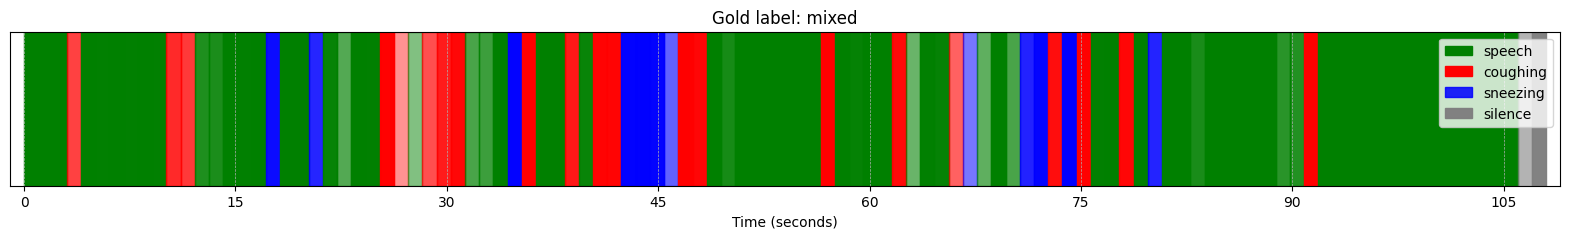

In [20]:
# testing
eg_label = "mixed"
eg_filename = "qPo0bymnsh0.wav"
eg_f = os.path.join(directory, eg_label, eg_filename)
eg_x, eg_sr = librosa.load(eg_f)
eg_y_labels, eg_y_probs = predict_framewise(eg_x)
print(eg_y_labels)
print(eg_y_probs)

chunk_duration = 1.0   # in second

eg_audio_duration = chunk_duration*len(eg_y_labels)
eg_timestamps = np.linspace(start=0, stop=eg_audio_duration, num=len(eg_y_labels))
plotter = TimescalePlotter(list(eg_timestamps), list(eg_y_labels), list(eg_y_probs), eg_filename, eg_label)
plotter.plot()
